# Bitcoin prediction model using XGBoost, feature and and time series, combined with CVGridSearch to yield optimal results.

In [2]:
!pip install kagglehub
!pip install ta
!pip install xgboost

# Import Libraries

In [14]:
import pandas as pd
import numpy as np
import ta
import kagglehub
from kagglehub import KaggleDatasetAdapter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score,
    confusion_matrix, classification_report, auc
)
from xgboost import XGBClassifier
import joblib
import warnings

In [4]:
warnings.filterwarnings('ignore')
SEED = 42
np.random.seed(SEED)

# Load data

In [5]:
def load_data():
    """Load dataset from Kaggle and perform initial processing."""
    try:
        file_path = "btc_1d_data_2018_to_2025.csv"
        df = kagglehub.load_dataset(
            KaggleDatasetAdapter.PANDAS,
            "novandraanugrah/bitcoin-historical-datasets-2018-2024",
            file_path
        )

        # Convert and sort
        df["Open time"] = pd.to_datetime(df["Open time"])
        df["Close time"] = pd.to_datetime(df["Close time"])

        df = df.sort_values("Open time").reset_index(drop=True)

        df.drop(columns=["Ignore", "Close time"], inplace=True)

        print(f"Data loaded successfully. Shape: {df.shape}")
        return df

    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# Feature Engineering

In [6]:
def create_features(df, threshold=0.005):
    # Target variable: 1 if price increase > threshold, else 0
    df["target"] = ((df["Close"].shift(-1) - df["Close"]) / df["Close"] > threshold).astype(int)

    # Price Returns
    df["return_1d"] = df["Close"].pct_change()
    df["return_3d"] = df["Close"].pct_change(3)
    df["return_7d"] = df["Close"].pct_change(7)
    df["return_14d"] = df["Close"].pct_change(14)

    # Volatility
    df["volatility_7d"] = df["return_1d"].rolling(7).std()
    df["volatility_14d"] = df["return_1d"].rolling(14).std()

    # Moving Averages & EMA
    windows = [5, 10, 20, 50]
    for w in windows:
        df[f"ma_{w}"] = df["Close"].rolling(w).mean()
        df[f"ema_{w}"] = df["Close"].ewm(span=w).mean()

    # MA ratios
    df["ma_ratio_5_20"] = df["ma_5"] / df["ma_20"]
    df["ema_ratio_5_20"] = df["ema_5"] / df["ema_20"]

    # Bollinger Bands
    bb = ta.volatility.BollingerBands(df["Close"], window=20, window_dev=2)
    df["bb_upper"] = bb.bollinger_hband()
    df["bb_lower"] = bb.bollinger_lband()
    df["bb_width"] = df["bb_upper"] - df["bb_lower"]
    df["bb_position"] = (df["Close"] - df["bb_lower"]) / df["bb_width"]

    # MACD & RSI
    macd = ta.trend.MACD(df["Close"])
    df["macd"] = macd.macd()
    df["macd_signal"] = macd.macd_signal()
    df["macd_cross"] = (df["macd"] > df["macd_signal"]).astype(int)

    df["rsi_14"] = ta.momentum.RSIIndicator(df["Close"], window=14).rsi()

    # ATR
    df["atr_14"] = ta.volatility.AverageTrueRange(df["High"], df["Low"], df["Close"], window=14).average_true_range()

    # Volume Features
    df["volume_change_1d"] = df["Volume"].pct_change()
    df["volume_ma_5"] = df["Volume"].rolling(5).mean()
    df["volume_ma_10"] = df["Volume"].rolling(10).mean()
    df["volume_ratio"] = df["Volume"] / df["volume_ma_10"]

    # OBV
    df["obv"] = ta.volume.OnBalanceVolumeIndicator(df["Close"], df["Volume"]).on_balance_volume()

    # Additional Price Ratios
    df["close_open_ratio"] = df["Close"] / df["Open"]
    df["high_low_ratio"] = df["High"] / df["Low"]

    # --------------------------
    # Time Features
    # --------------------------
    df["day_of_week"] = df["Open time"].dt.dayofweek
    df["month"] = df["Open time"].dt.month
    df["is_month_start"] = df["Open time"].dt.is_month_start.astype(int)
    df["is_month_end"] = df["Open time"].dt.is_month_end.astype(int)

    # Lag Features
    lag_features = ["return_1d", "volume_change_1d", "rsi_14", "ma_ratio_5_20", "bb_position", "close_open_ratio", "high_low_ratio"]
    for feature in lag_features:
        for lag in range(1, 11):
            df[f"{feature}_lag_{lag}"] = df[feature].shift(lag)

    # Rolling Statistics
    rolling_features = ["return_1d", "volume_change_1d", "rsi_14"]
    for feature in rolling_features:
        df[f"{feature}_roll_3_mean"] = df[feature].rolling(3).mean()
        df[f"{feature}_roll_7_mean"] = df[feature].rolling(7).mean()
        df[f"{feature}_roll_14_mean"] = df[feature].rolling(14).mean()
        df[f"{feature}_roll_3_std"] = df[feature].rolling(3).std()
        df[f"{feature}_roll_7_std"] = df[feature].rolling(7).std()
        df[f"{feature}_roll_14_std"] = df[feature].rolling(14).std()

    df = df.dropna().reset_index(drop=True)
    print(f"Features created. Shape: {df.shape}")
    return df

# Preprocessing

In [7]:
def preprocess_data(df):
    non_features = ["Open time", "target"]
    features = [c for c in df.columns if c not in non_features]
    X = df[features]
    y = df["target"]

    # Time-based train/test split
    test_size = 0.2
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Scaling
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    joblib.dump(scaler, 'btc_scaler.pkl')
    return X_train_scaled, X_test_scaled, y_train, y_test, features

# Training model

In [8]:
def train_model(X_train, y_train):
    # TimeSeries cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    model = XGBClassifier(
        n_estimators=500,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=SEED,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        eval_metric='logloss',
        n_jobs=-1
    )

    param_grid = {
        "max_depth": [4,5,6],
        "learning_rate": [0.03,0.05,0.07],
        "subsample": [0.7,0.8,0.9],
        "colsample_bytree": [0.7,0.8,0.9]
    }

    grid = GridSearchCV(model, param_grid, cv=tscv, scoring='f1_weighted', n_jobs=-1)
    grid.fit(X_train, y_train)

    print(f"Best params: {grid.best_params_}")
    return grid.best_estimator_

# Evaluate model

In [9]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, y_proba)
    }

    cm = pd.DataFrame(
        confusion_matrix(y_test, y_pred),
        index=['Actual Down','Actual Up'],
        columns=['Pred Down','Pred Up']
    )

    report = classification_report(y_test, y_pred, target_names=['Down','Up'])

    return metrics, cm, report

# Plotting

In [23]:
def plot_close_price(df):
    plt.figure(figsize=(12,6))
    plt.plot(df["Open time"], df["Close"], label="BTC Close Price", color="blue")
    plt.title("Bitcoin Close Price Over Time")
    plt.xlabel("Date")
    plt.ylabel("Close Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_correlation(df):
    plt.figure(figsize=(12,8))
    corr = df.corr()
    sns.heatmap(corr, cmap="coolwarm", center=0)
    plt.title("Feature Correlation Heatmap")
    plt.show()

def plot_feature_importance(model, features):
    plt.figure(figsize=(12,6))
    importances = model.feature_importances_
    idx = np.argsort(importances)[-20:]  # Top 20 features
    plt.barh(range(len(idx)), importances[idx], align="center")
    plt.yticks(range(len(idx)), [features[i] for i in idx])
    plt.title("Top 20 Feature Importances (XGBoost)")
    plt.show()

def plot_roc_curve(y_test, y_proba):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

def plot_predictions(y_test, y_pred, df):
    plt.figure(figsize=(14,6))
    dates = df["Open time"].iloc[-len(y_test):]
    plt.plot(dates, y_test.values, label="Actual", color="blue")
    plt.plot(dates, y_pred, label="Predicted", color="red", alpha=0.7)
    plt.title("Actual vs Predicted Signals (0=Down, 1=Up)")
    plt.xlabel("Date")
    plt.ylabel("Signal")
    plt.legend()
    plt.show()

# Define trading strategy

In [44]:
def apply_strategy(df, strategy=1, horizon=1):

    df['future_close'] = df['Close'].shift(-horizon)
    df.dropna(inplace=True)

    if strategy == 1:  # Always Hold
        df['move'] = np.where(df['target'] == 1, 2, 0)

    elif strategy == 2:  # Momentum Trading
        df['move'] = np.where(
            (df['target'] == 1) & (df['future_close'] > df['Close']), 2,   # Buy before it increases
            np.where((df['target'] == 1) & (df['future_close'] < df['Close']), 1, 0)  # Sell/Hold
        )

    elif strategy == 3:  # Swing Trading - prices that are going up tend to keep going up, and prices that are going down tend to keep going down.
        df['move'] = np.where(
            (df['target'] == 1) & (df['future_close'] > df['Close'] * 1.05), 2,
            np.where((df['target'] == 1) & (df['future_close'] < df['Close'] * 0.95), 1, 0)
        )

    elif strategy == 4:  # Mean Reversion - Prices often return to their “average” level. This strategy uses a 20-day rolling average
        rolling_mean = df['Close'].rolling(window=20, min_periods=1).mean()
        df['move'] = np.where(
            (df['target'] == 1) & (df['Close'] < rolling_mean * 0.97), 2,
            np.where((df['target'] == 1) & (df['Close'] > rolling_mean * 1.03), 1, 0)
        )

    elif strategy == 5:  # Simple Volatility-based - Looks at how “wild” the day’s trading range is.
        if all(col in df.columns for col in ['High','Low','Close']):
            df['volatility'] = (df['High'] - df['Low']) / df['Close']
            df['move'] = np.where(
                (df['target'] == 1) & (df['volatility'] < 0.02), 2,
                np.where((df['target'] == 1) & (df['volatility'] > 0.08), 1, 0)
            )
        else:
            raise ValueError("Strategy 5 requires High & Low columns")

    else:
        raise ValueError("Unknown strategy.")

    return df
# 2 = buy
# 1 = sell
# 0 = hold

# Execution

In [25]:
df = load_data()
if df is None:
  print("Error loading data.")

Data loaded successfully. Shape: (2785, 10)


# Check if target is balanced

In [38]:
print(df['target'].value_counts())

target
0    1623
1    1113
Name: count, dtype: int64


In [26]:
df = create_features(df)
X_train, X_test, y_train, y_test, features = preprocess_data(df)

Features created. Shape: (2736, 135)


In [27]:
print("Training model...")
model = train_model(X_train, y_train)

Training model...
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 5, 'subsample': 0.8}


In [28]:
print("Evaluating model...")
metrics, cm, report = evaluate_model(model, X_test, y_test)

Evaluating model...


In [33]:
print("\nMetrics:")
for k,v in metrics.items():
    print(f"{k}: {v:.4f}")

print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(report)

joblib.dump({"model": model, "features": features}, "btc_model_improved.pkl")
print("\nModel saved to btc_model_improved.pkl")


Metrics:
Accuracy: 0.6168
Precision: 0.6875
Recall: 0.0509
F1: 0.0948
ROC_AUC: 0.5505

Confusion Matrix:
             Pred Down  Pred Up
Actual Down        327        5
Actual Up          205       11

Classification Report:
              precision    recall  f1-score   support

        Down       0.61      0.98      0.76       332
          Up       0.69      0.05      0.09       216

    accuracy                           0.62       548
   macro avg       0.65      0.52      0.43       548
weighted avg       0.64      0.62      0.50       548


Model saved to btc_model_improved.pkl


**NOTE: We use the future price combined with our prediction to show how trading strategies work. By only using only our model, we would not know how big the price increase would be.**

In [45]:
df = apply_strategy(df, strategy=3, horizon=3)  # Swing trading with 3-day horizon
df

,Open time,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,...,volume_change_1d_roll_7_std,volume_change_1d_roll_14_std,rsi_14_roll_3_mean,rsi_14_roll_7_mean,rsi_14_roll_14_mean,rsi_14_roll_3_std,rsi_14_roll_7_std,rsi_14_roll_14_std,future_close,move
0,2018-02-19 00:00:00+00:00,10375.01,11250.00,10270.33,11153.00,40831.417131,4.437666e+08,366882,20619.877129,2.241937e+08,...,0.295950,3.361601,56.305638,51.888424,44.147198,2.639848,5.675405,9.521483,9811.04,1
1,2018-02-20 00:00:00+00:00,11147.11,11786.01,11100.59,11200.99,48153.354288,5.515732e+08,432197,24211.491810,2.774809e+08,...,0.287267,3.366608,56.271011,54.221482,46.056180,2.606781,3.764095,9.400210,10131.04,1
2,2018-02-21 00:00:00+00:00,11195.07,11304.03,10200.00,10437.60,68113.818754,7.315371e+08,542340,32338.074002,3.474366e+08,...,0.313971,3.349399,55.951423,54.808436,47.579718,3.159734,2.886119,8.448490,9694.51,1
3,2018-02-22 00:00:00+00:00,10439.02,10933.44,9679.00,9811.04,67060.166483,6.820064e+08,506273,33029.297624,3.360674e+08,...,0.307983,3.316209,52.799785,54.298422,48.690872,4.878599,3.712398,7.272231,9590.00,0
4,2018-02-23 00:00:00+00:00,9815.55,10435.00,9570.19,10131.04,57202.702370,5.718008e+08,467480,28031.011368,2.801717e+08,...,0.287359,0.438420,50.276941,53.950600,49.419006,2.060311,3.983344,6.848649,10324.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2725,2025-08-06 00:00:00+00:00,114129.75,114139.38,113491.76,113679.97,683.682040,7.781504e+07,192310,274.639480,3.125942e+07,...,1.089909,1.194614,46.412096,47.698650,54.049973,1.937207,5.460833,7.843906,116506.38,0
2726,2025-08-07 00:00:00+00:00,114992.27,115185.58,114580.53,114769.70,808.035040,9.279900e+07,124082,386.324840,4.437327e+07,...,1.010085,1.189622,46.571668,46.206676,52.843994,2.114689,2.680109,7.289807,116734.75,0
2727,2025-08-08 00:00:00+00:00,117472.02,117630.00,116770.05,116788.74,1591.161200,1.863293e+08,392897,674.397100,7.897877e+07,...,0.628229,0.888694,49.064923,46.933507,52.609758,5.338103,4.095750,7.161237,121459.83,0
2728,2025-08-09 00:00:00+00:00,116674.74,116750.00,116506.38,116506.38,357.129900,4.164915e+07,74662,161.787320,1.886793e+07,...,0.623674,0.882882,52.250427,48.372206,52.271143,3.516132,4.509105,6.971447,118968.74,0


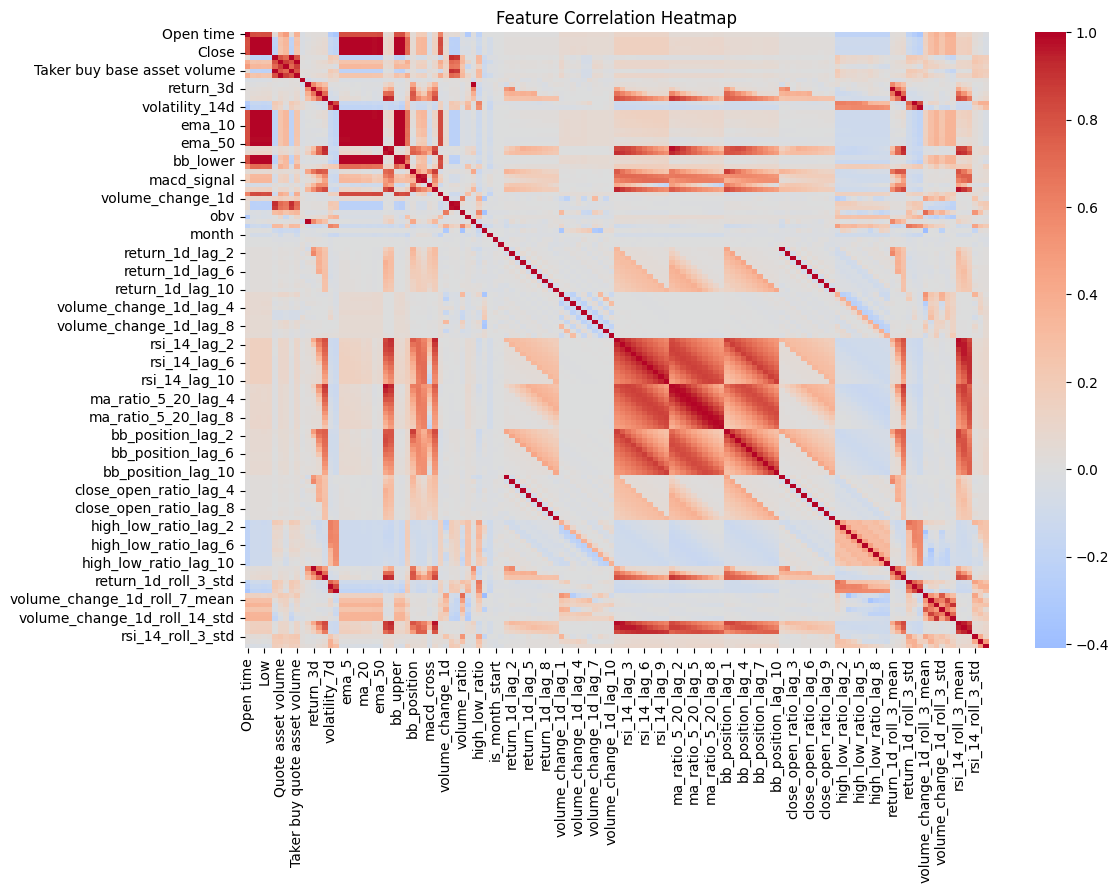

In [34]:
plot_correlation(df)

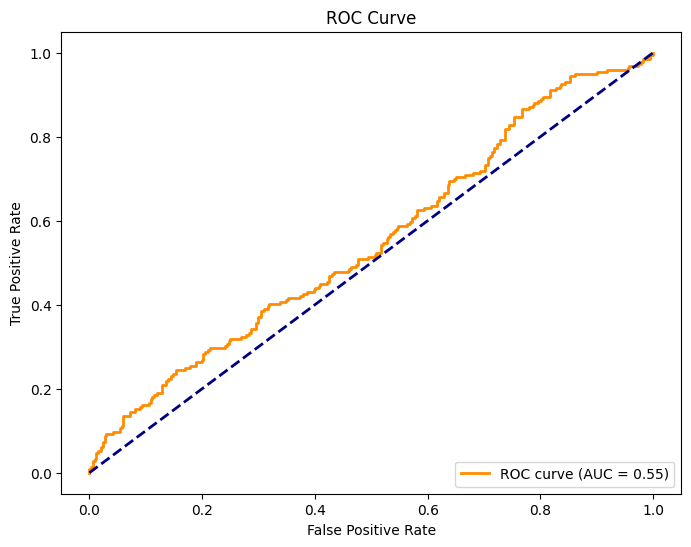

In [35]:
plot_roc_curve(y_test, model.predict_proba(X_test)[:,1])

**An ROC curve, or Receiver Operating Characteristic curve, is a plot that shows how well a binary classification model distinguishes between the two classes at different decision thresholds.**

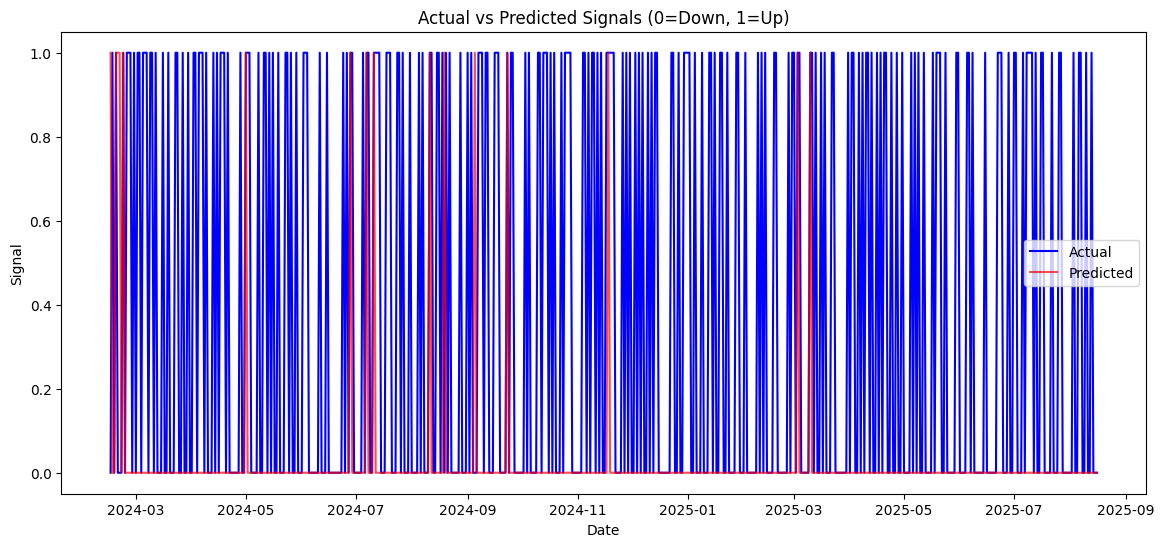

In [36]:
plot_predictions(y_test, model.predict(X_test), df)

# **Summary**

# This project implements a machine learning model to predict daily Bitcoin price movements based on historical market data. Using a combination of technical indicators, lag features, volatility measures, and time-based features, the model attempts to classify whether the price will increase or decrease the next day.

# The model achieves an overall accuracy of 62%, indicating it captures general trends in the market. However, performance is asymmetric across classes: it is highly effective at identifying price decreases (recall ≈ 98%), but struggles to correctly predict price increases (recall ≈ 5%). This suggests that while the model is conservative and avoids false positives for price drops, it has difficulty capturing upward movements, which are less frequent in the dataset.

# Key contributions include:

#Extensive feature engineering incorporating price returns, moving averages, RSI, MACD, Bollinger Bands, ATR, volume features, and lagged/rolling statistics.

#Implementation of a time-series aware train/test split to prevent data leakage.

#Use of XGBoost with class balancing to account for moderately imbalanced target distribution.

#Comprehensive evaluation and visualization, including feature importance, correlation heatmaps, ROC curves, and prediction accuracy over time.

#Overall, the project demonstrates the challenges of predicting highly volatile financial markets and provides a foundation for further improvements, such as enhancing prediction of upward trends or incorporating alternative data sources.